In [1]:
#matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from dataset.dataloader import *
import operators as ops
import torch
import os

CKPT_DIR = "./logs/checkpoints"
LOAD_PRETRAINED = True

In [2]:
import torch.nn as nn
import torch

class torch_VGG8(nn.Module):
    def __init__(self):
        super(torch_VGG8, self,).__init__()
        # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
        self.Layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 2 (B, 32, 28, 28) -> (B, 64, 14, 14)
        self.Layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
        self.Layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
        self.Layer4 =nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
        self.Layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
        self.Layer6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.Layer7 = nn.Sequential(
            nn.Linear(in_features=256*7*7, out_features=256, bias=True,),
            nn.ReLU(True)
        )
        # Layer 8 (B, 256) -> (B, 10)
        self.Layer8 = nn.Sequential(
            nn.Linear(in_features=256, out_features=10, bias=True,),
        )

    def forward(self, x):
        # L1~L6: Conv + ReLU + (MaxPool)
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Layer4(x)
        x = self.Layer5(x)
        x = self.Layer6(x)
        # L7: FC + ReLU
        x = x.view(x.size(0), -1)
        x = self.Layer7(x)
        # L8: FC
        x = self.Layer8(x)
        return x


In [3]:
class VGG8:
    def __init__(self):
        self.criterion = ops.SoftmaxWithLoss()
        self.conv_layers = [
            # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
            ops.Conv2D(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1, name="L1_C"),
            ops.ReLU(name="L1_R"),

            # Layer2 (B, 32, 28, 28) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, name="L2_C"),
            ops.ReLU(name="L2_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L2_M"),
            
            # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1, name="L3_C"),
            ops.ReLU(name="L3_R"),

            # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
            ops.Conv2D(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1, name="L4_C"),
            ops.ReLU(name="L4_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L4_M"),

            # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, name="L5_C"),
            ops.ReLU(name="L5_R"),

            # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, name="L6_C"),
            ops.ReLU(name="L6_R")
        ]

        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.fc_layers = [
            ops.FullyConnected(in_feature=256*7*7, out_feature=256, name="L7_FC"),
            ops.ReLU(name="L7_R"),

        # Layer 8 (B, 256) -> (B, 10)
            ops.FullyConnected(in_feature=256, out_feature=10, name="L8_FC")
        ]

    def backprop(self, lr, m=None) -> None:
        # Backward
        #dout = self.criterion.backward(pred, label)
        dout = self.criterion.backward()
        for i in range(len(self.fc_layers)-1, -1, -1):
            dout = self.fc_layers[i].backward(dout)
        dout = dout.reshape(dout.shape[0], 256, 7, 7)
        for i in range(len(self.conv_layers)-1, -1, -1):
            dout = self.conv_layers[i].backward(dout)
        # Update
        for layer in self.conv_layers:
            layer.update(lr, m)
        for layer in self.fc_layers:
            layer.update(lr, m)
        return dout

    def forward(self, x: np.ndarray):
        i = 0
        for layer in self.conv_layers:
            i+=1
            x = layer.forward(x) 
        x = x.reshape(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer.forward(x)
        return x

    def save(self, fileName: str):
        with open(fileName, "wb") as f:
            pickle.dump(self, f)

    def load(self, fileName: str):
        with open(fileName, "rb") as f:
            self = pickle.load(f)

In [4]:
model = VGG8()

In [5]:
if LOAD_PRETRAINED:
    # Load pretrained weights from torch
    torch_vgg8 = torch_VGG8()
    torch_vgg8.load_state_dict(torch.load("torch_vgg8.pt"))

    for i, p in enumerate(torch_vgg8.Layer1.parameters()):
        if (i == 0):
            print(f"Load L1 Weight:({p.shape},{model.conv_layers[0].W.shape})")
            model.conv_layers[0].W = p.detach().numpy()
        else:
            print(f"Load L1 Bias({model.conv_layers[0].b.shape},{p.shape})")
            model.conv_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer2.parameters()):
        print(torch_vgg8.Layer2)
        if (i == 0):
            print(f"Load L2 Weight:({p.shape},{model.conv_layers[2].W.shape})")
            model.conv_layers[2].W = p.detach().numpy()
        else:
            print(f"Load L2 Bias({model.conv_layers[2].b.shape},{p.shape})")
            model.conv_layers[2].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer3.parameters()):
        if (i == 0):
            print(f"Load L3 Weight:({p.shape},{model.conv_layers[5].W.shape})")
            model.conv_layers[5].W = p.detach().numpy()
        else:
            print(f"Load L3 Bias({model.conv_layers[5].b.shape},{p.shape})")
            model.conv_layers[5].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer4.parameters()):
        if (i == 0):
            print(f"Load L4 Weight:({p.shape},{model.conv_layers[7].W.shape})")
            model.conv_layers[7].W = p.detach().numpy()
        else:
            print(f"Load L4 Bias({model.conv_layers[7].b.shape},{p.shape})")
            model.conv_layers[7].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer5.parameters()):
        if (i == 0):
            print(f"Load L5 Weight:({p.shape},{model.conv_layers[10].W.shape})")
            model.conv_layers[10].W = p.detach().numpy()
        else:
            print(f"Load L5 Bias({model.conv_layers[10].b.shape},{p.shape})")
            model.conv_layers[10].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer6.parameters()):
        if (i == 0):
            print(f"Load L6 Weight:({p.shape},{model.conv_layers[12].W.shape})")
            model.conv_layers[12].W = p.detach().numpy()
        else:
            print(f"Load L6 Bias({model.conv_layers[12].b.shape},{p.shape})")
            model.conv_layers[12].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer7.parameters()):
        if (i == 0):
            print(f"Load L7 Weight:({p.shape},{model.fc_layers[0].W.shape})")
            model.fc_layers[0].W = p.T.detach().numpy()
        else:
            print(f"Load L7 Bias({model.fc_layers[0].b.shape},{p.shape})")
            model.fc_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer8.parameters()):
        if (i == 0):
            print(f"Load L8 Weight:({p.shape},{model.fc_layers[2].W.shape})")
            model.fc_layers[2].W = p.T.detach().numpy()
        else:
            print(f"Load L8 Bias({model.fc_layers[2].b.shape},{p.shape})")
            model.fc_layers[2].b = p.detach().numpy()

Load L1 Weight:(torch.Size([32, 1, 3, 3]),(32, 1, 3, 3))
Load L1 Bias((32,),torch.Size([32]))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Weight:(torch.Size([64, 32, 3, 3]),(64, 32, 3, 3))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Bias((64,),torch.Size([64]))
Load L3 Weight:(torch.Size([64, 64, 3, 3]),(64, 64, 3, 3))
Load L3 Bias((64,),torch.Size([64]))
Load L4 Weight:(torch.Size([128, 64, 3, 3]),(128, 64, 3, 3))
Load L4 Bias((128,),torch.Size([128]))
Load L5 Weight:(torch.Size([256, 128, 3, 3]),(256, 128, 3, 3))
Load L5 Bias((256,),torch.Size([256]))
Load L6 Weight:(torch.Size([256, 256, 3, 3]),(256, 256, 3, 3))
Load L6 Bias((256,),torch.Size([256]))
Load L7 Weight:(torc

In [13]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

batch_size = 50
learning_rate = 0.01
#momentum = 0.9
momentum = None     # Not use momentum
loss_print_time = 5
accuracy_print_time = loss_print_time * 5
x_log = []
loss_log = []

print(f"Train:{x_train.shape}, Test:{x_test.shape}")

def accuracy_check(model, x_test, t_test, test_size):
    total_correct = 0

    test_data_idx = np.random.choice(x_test.shape[0], test_size)
    for i in tqdm(test_data_idx):
        x = x_test[i].reshape(1, 1, 28, 28)
        labels = t_test[i]

        outputs = model.forward(x)
        pred = ops.Softmax(outputs)
        labels = labels.reshape(pred.shape)
        c = (np.argmax(labels, 1) == np.argmax(pred, 1)).squeeze()
        total_correct += np.sum(c)
    return total_correct/test_size
    #print(f"Accuracy:{total_correct/test_size}")


Train:(60000, 784), Test:(10000, 784)


In [7]:
for epoch in range(10):
    accuracy = 0.0
    train_size = x_train.shape[0]
    running_loss = []
    for i, b in tqdm(enumerate(range(0, train_size, batch_size))):
        x = x_train[b:b+batch_size].reshape(batch_size, 1, 28, 28)   # B, C, H, W
        labels = t_train[b:b+batch_size]
        #optimizer.zero_grad()

        outputs = model.forward(x)
        loss = model.criterion.forward(outputs, labels)
        running_loss.append(loss)
        model.backprop(learning_rate, momentum)

        if (i % loss_print_time == 0):
            if (i % accuracy_print_time == 0):
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}, Accuracy: {accuracy_check(model, x_test, t_test, 100)}')
            else:
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}')
            loss_log += running_loss
            running_loss = []
            #model.save(os.path.join(CKPT_DIR, "epoch_%03d_%06d.pkl" % (epoch, i) ))




100%|██████████| 100/100 [00:01<00:00, 91.55it/s]
1it [00:02,  2.40s/it]

[epoch:0, data num:0] Avg Loss: 2.200621, Max Loss: 2.200621, Min Loss: 2.200621, Accuracy: 0.36


6it [00:07,  1.09s/it]

[epoch:0, data num:250] Avg Loss: 2.174982, Max Loss: 2.197398, Min Loss: 2.157605


11it [00:12,  1.03it/s]

[epoch:0, data num:500] Avg Loss: 2.182700, Max Loss: 2.213145, Min Loss: 2.148148


16it [00:17,  1.04it/s]

[epoch:0, data num:750] Avg Loss: 2.180271, Max Loss: 2.206374, Min Loss: 2.160433


21it [00:21,  1.06it/s]

[epoch:0, data num:1000] Avg Loss: 2.165117, Max Loss: 2.190412, Min Loss: 2.132191


100%|██████████| 100/100 [00:01<00:00, 90.71it/s]
26it [00:27,  1.31s/it]

[epoch:0, data num:1250] Avg Loss: 2.154774, Max Loss: 2.178883, Min Loss: 2.122019, Accuracy: 0.61


31it [00:32,  1.06s/it]

[epoch:0, data num:1500] Avg Loss: 2.121231, Max Loss: 2.153567, Min Loss: 2.095498


36it [00:37,  1.03it/s]

[epoch:0, data num:1750] Avg Loss: 2.067081, Max Loss: 2.132733, Min Loss: 1.994248


41it [00:42,  1.03it/s]

[epoch:0, data num:2000] Avg Loss: 2.039867, Max Loss: 2.063726, Min Loss: 2.005701


46it [00:47,  1.05it/s]

[epoch:0, data num:2250] Avg Loss: 1.965655, Max Loss: 2.010549, Min Loss: 1.922879


100%|██████████| 100/100 [00:01<00:00, 93.36it/s]
51it [00:53,  1.27s/it]

[epoch:0, data num:2500] Avg Loss: 1.922374, Max Loss: 1.964131, Min Loss: 1.876239, Accuracy: 0.57


56it [00:57,  1.00it/s]

[epoch:0, data num:2750] Avg Loss: 1.837250, Max Loss: 1.961504, Min Loss: 1.763421


61it [01:02,  1.02it/s]

[epoch:0, data num:3000] Avg Loss: 1.696707, Max Loss: 1.780714, Min Loss: 1.502171


66it [01:07,  1.02it/s]

[epoch:0, data num:3250] Avg Loss: 1.666554, Max Loss: 1.814787, Min Loss: 1.571664


71it [01:12,  1.06it/s]

[epoch:0, data num:3500] Avg Loss: 1.599296, Max Loss: 1.710672, Min Loss: 1.506258


100%|██████████| 100/100 [00:01<00:00, 84.63it/s]
76it [01:18,  1.38s/it]

[epoch:0, data num:3750] Avg Loss: 1.402063, Max Loss: 1.536974, Min Loss: 1.275563, Accuracy: 0.48


81it [01:23,  1.01s/it]

[epoch:0, data num:4000] Avg Loss: 1.230892, Max Loss: 1.368979, Min Loss: 1.114731


86it [01:28,  1.03it/s]

[epoch:0, data num:4250] Avg Loss: 1.296053, Max Loss: 1.538974, Min Loss: 1.042564


91it [01:33,  1.00s/it]

[epoch:0, data num:4500] Avg Loss: 1.144601, Max Loss: 1.427142, Min Loss: 0.876550


96it [01:37,  1.04it/s]

[epoch:0, data num:4750] Avg Loss: 1.186683, Max Loss: 1.719748, Min Loss: 0.805727


100%|██████████| 100/100 [00:01<00:00, 90.79it/s]
101it [01:43,  1.30s/it]

[epoch:0, data num:5000] Avg Loss: 1.065991, Max Loss: 1.331613, Min Loss: 0.909946, Accuracy: 0.72


106it [01:48,  1.00it/s]

[epoch:0, data num:5250] Avg Loss: 1.021936, Max Loss: 1.131255, Min Loss: 0.925650


111it [01:53,  1.05it/s]

[epoch:0, data num:5500] Avg Loss: 0.947470, Max Loss: 1.240086, Min Loss: 0.725806


116it [01:58,  1.03it/s]

[epoch:0, data num:5750] Avg Loss: 1.001385, Max Loss: 1.275617, Min Loss: 0.832665


121it [02:03,  1.03it/s]

[epoch:0, data num:6000] Avg Loss: 0.796487, Max Loss: 0.900822, Min Loss: 0.661676


100%|██████████| 100/100 [00:01<00:00, 91.43it/s]
126it [02:08,  1.26s/it]

[epoch:0, data num:6250] Avg Loss: 0.797602, Max Loss: 1.052737, Min Loss: 0.601343, Accuracy: 0.57


131it [02:14,  1.07s/it]

[epoch:0, data num:6500] Avg Loss: 0.711955, Max Loss: 0.813429, Min Loss: 0.605984


136it [02:18,  1.02it/s]

[epoch:0, data num:6750] Avg Loss: 0.606617, Max Loss: 0.696600, Min Loss: 0.511630


141it [02:24,  1.04s/it]

[epoch:0, data num:7000] Avg Loss: 1.099524, Max Loss: 1.390232, Min Loss: 0.831322


146it [02:29,  1.04it/s]

[epoch:0, data num:7250] Avg Loss: 0.740392, Max Loss: 0.951074, Min Loss: 0.620202


100%|██████████| 100/100 [00:01<00:00, 91.54it/s]
151it [02:35,  1.29s/it]

[epoch:0, data num:7500] Avg Loss: 0.742514, Max Loss: 0.866396, Min Loss: 0.629104, Accuracy: 0.78


156it [02:40,  1.03s/it]

[epoch:0, data num:7750] Avg Loss: 0.720684, Max Loss: 0.866765, Min Loss: 0.437406


161it [02:44,  1.05it/s]

[epoch:0, data num:8000] Avg Loss: 0.816793, Max Loss: 1.179011, Min Loss: 0.631423


166it [02:49,  1.08it/s]

[epoch:0, data num:8250] Avg Loss: 0.683539, Max Loss: 0.926198, Min Loss: 0.413705


171it [02:54,  1.02it/s]

[epoch:0, data num:8500] Avg Loss: 0.777071, Max Loss: 1.026602, Min Loss: 0.465420


100%|██████████| 100/100 [00:01<00:00, 93.53it/s]
176it [03:00,  1.30s/it]

[epoch:0, data num:8750] Avg Loss: 0.740979, Max Loss: 0.988040, Min Loss: 0.515517, Accuracy: 0.75


181it [03:05,  1.04s/it]

[epoch:0, data num:9000] Avg Loss: 0.583407, Max Loss: 1.024977, Min Loss: 0.375691


186it [03:09,  1.03it/s]

[epoch:0, data num:9250] Avg Loss: 0.552816, Max Loss: 0.610242, Min Loss: 0.457221


191it [03:14,  1.07it/s]

[epoch:0, data num:9500] Avg Loss: 0.563704, Max Loss: 0.673554, Min Loss: 0.436615


196it [03:19,  1.09it/s]

[epoch:0, data num:9750] Avg Loss: 0.543908, Max Loss: 0.778709, Min Loss: 0.402546


100%|██████████| 100/100 [00:01<00:00, 96.16it/s]
201it [03:24,  1.24s/it]

[epoch:0, data num:10000] Avg Loss: 0.491667, Max Loss: 0.715709, Min Loss: 0.391365, Accuracy: 0.83


206it [03:29,  1.04s/it]

[epoch:0, data num:10250] Avg Loss: 0.544273, Max Loss: 0.641713, Min Loss: 0.485526


211it [03:34,  1.01it/s]

[epoch:0, data num:10500] Avg Loss: 0.377246, Max Loss: 0.525662, Min Loss: 0.265787


216it [03:39,  1.03it/s]

[epoch:0, data num:10750] Avg Loss: 0.618066, Max Loss: 0.808108, Min Loss: 0.402471


221it [03:44,  1.07it/s]

[epoch:0, data num:11000] Avg Loss: 0.445858, Max Loss: 0.543640, Min Loss: 0.346258


100%|██████████| 100/100 [00:01<00:00, 91.49it/s]
226it [03:49,  1.26s/it]

[epoch:0, data num:11250] Avg Loss: 0.543224, Max Loss: 0.590502, Min Loss: 0.473976, Accuracy: 0.86


231it [03:54,  1.02s/it]

[epoch:0, data num:11500] Avg Loss: 0.412072, Max Loss: 0.603228, Min Loss: 0.313874


236it [03:59,  1.03it/s]

[epoch:0, data num:11750] Avg Loss: 0.672039, Max Loss: 0.977077, Min Loss: 0.458971


241it [04:04,  1.02it/s]

[epoch:0, data num:12000] Avg Loss: 0.421080, Max Loss: 0.511440, Min Loss: 0.345884


246it [04:09,  1.05it/s]

[epoch:0, data num:12250] Avg Loss: 0.456325, Max Loss: 0.600164, Min Loss: 0.228924


100%|██████████| 100/100 [00:01<00:00, 93.51it/s]
251it [04:15,  1.27s/it]

[epoch:0, data num:12500] Avg Loss: 0.665744, Max Loss: 0.741728, Min Loss: 0.558839, Accuracy: 0.8


256it [04:19,  1.00s/it]

[epoch:0, data num:12750] Avg Loss: 0.618912, Max Loss: 0.916505, Min Loss: 0.352339


261it [04:24,  1.01s/it]

[epoch:0, data num:13000] Avg Loss: 0.523261, Max Loss: 0.716329, Min Loss: 0.355984


266it [04:29,  1.02it/s]

[epoch:0, data num:13250] Avg Loss: 0.471097, Max Loss: 0.608551, Min Loss: 0.301584


271it [04:34,  1.03it/s]

[epoch:0, data num:13500] Avg Loss: 0.435601, Max Loss: 0.466720, Min Loss: 0.399001


100%|██████████| 100/100 [00:01<00:00, 92.83it/s]
276it [04:40,  1.29s/it]

[epoch:0, data num:13750] Avg Loss: 0.458589, Max Loss: 0.680787, Min Loss: 0.216750, Accuracy: 0.91


281it [04:45,  1.02it/s]

[epoch:0, data num:14000] Avg Loss: 0.540283, Max Loss: 0.750805, Min Loss: 0.372187


286it [04:49,  1.05it/s]

[epoch:0, data num:14250] Avg Loss: 0.623581, Max Loss: 0.821827, Min Loss: 0.498539


291it [04:55,  1.02s/it]

[epoch:0, data num:14500] Avg Loss: 0.645406, Max Loss: 0.954756, Min Loss: 0.331636


296it [05:00,  1.01s/it]

[epoch:0, data num:14750] Avg Loss: 0.593553, Max Loss: 0.789869, Min Loss: 0.354913


100%|██████████| 100/100 [00:01<00:00, 94.97it/s]
301it [05:06,  1.29s/it]

[epoch:0, data num:15000] Avg Loss: 0.411147, Max Loss: 0.602539, Min Loss: 0.231373, Accuracy: 0.84


306it [05:11,  1.03s/it]

[epoch:0, data num:15250] Avg Loss: 0.408959, Max Loss: 0.510593, Min Loss: 0.304463


311it [05:15,  1.04it/s]

[epoch:0, data num:15500] Avg Loss: 0.366707, Max Loss: 0.461705, Min Loss: 0.237896


316it [05:20,  1.02it/s]

[epoch:0, data num:15750] Avg Loss: 0.489169, Max Loss: 0.821316, Min Loss: 0.246373


321it [05:25,  1.04it/s]

[epoch:0, data num:16000] Avg Loss: 0.646253, Max Loss: 0.916835, Min Loss: 0.428604


100%|██████████| 100/100 [00:01<00:00, 97.63it/s]
326it [05:31,  1.29s/it]

[epoch:0, data num:16250] Avg Loss: 0.424047, Max Loss: 0.651888, Min Loss: 0.324658, Accuracy: 0.87


331it [05:36,  1.02s/it]

[epoch:0, data num:16500] Avg Loss: 0.332135, Max Loss: 0.450036, Min Loss: 0.212949


336it [05:41,  1.02it/s]

[epoch:0, data num:16750] Avg Loss: 0.466283, Max Loss: 0.713496, Min Loss: 0.334428


341it [05:46,  1.04it/s]

[epoch:0, data num:17000] Avg Loss: 0.426160, Max Loss: 0.589564, Min Loss: 0.341984


346it [05:51,  1.02it/s]

[epoch:0, data num:17250] Avg Loss: 0.416541, Max Loss: 0.510489, Min Loss: 0.349189


100%|██████████| 100/100 [00:01<00:00, 93.32it/s]
351it [05:57,  1.29s/it]

[epoch:0, data num:17500] Avg Loss: 0.449991, Max Loss: 0.741841, Min Loss: 0.196056, Accuracy: 0.86


356it [06:01,  1.00s/it]

[epoch:0, data num:17750] Avg Loss: 0.491871, Max Loss: 0.559031, Min Loss: 0.392318


361it [06:06,  1.03it/s]

[epoch:0, data num:18000] Avg Loss: 0.349064, Max Loss: 0.475203, Min Loss: 0.189634


366it [06:11,  1.06it/s]

[epoch:0, data num:18250] Avg Loss: 0.276761, Max Loss: 0.376600, Min Loss: 0.186841


371it [06:16,  1.07it/s]

[epoch:0, data num:18500] Avg Loss: 0.400376, Max Loss: 0.605836, Min Loss: 0.240357


100%|██████████| 100/100 [00:01<00:00, 91.77it/s]
376it [06:21,  1.29s/it]

[epoch:0, data num:18750] Avg Loss: 0.338211, Max Loss: 0.542422, Min Loss: 0.212691, Accuracy: 0.88


381it [06:26,  1.02s/it]

[epoch:0, data num:19000] Avg Loss: 0.309037, Max Loss: 0.473623, Min Loss: 0.190743


386it [06:31,  1.06it/s]

[epoch:0, data num:19250] Avg Loss: 0.397660, Max Loss: 0.448788, Min Loss: 0.316844


391it [06:36,  1.03it/s]

[epoch:0, data num:19500] Avg Loss: 0.324901, Max Loss: 0.459363, Min Loss: 0.138552


396it [06:41,  1.04it/s]

[epoch:0, data num:19750] Avg Loss: 0.202633, Max Loss: 0.395817, Min Loss: 0.090467


100%|██████████| 100/100 [00:01<00:00, 96.01it/s]
401it [06:46,  1.24s/it]

[epoch:0, data num:20000] Avg Loss: 0.400079, Max Loss: 0.486759, Min Loss: 0.268268, Accuracy: 0.85


406it [06:51,  1.03s/it]

[epoch:0, data num:20250] Avg Loss: 0.396283, Max Loss: 0.768717, Min Loss: 0.217170


411it [06:56,  1.00s/it]

[epoch:0, data num:20500] Avg Loss: 0.266695, Max Loss: 0.358286, Min Loss: 0.192276


416it [07:01,  1.05it/s]

[epoch:0, data num:20750] Avg Loss: 0.436780, Max Loss: 0.540237, Min Loss: 0.329214


421it [07:06,  1.05it/s]

[epoch:0, data num:21000] Avg Loss: 0.492253, Max Loss: 0.630041, Min Loss: 0.297949


100%|██████████| 100/100 [00:01<00:00, 95.51it/s]
426it [07:12,  1.28s/it]

[epoch:0, data num:21250] Avg Loss: 0.298461, Max Loss: 0.365671, Min Loss: 0.160295, Accuracy: 0.92


431it [07:16,  1.02it/s]

[epoch:0, data num:21500] Avg Loss: 0.307397, Max Loss: 0.390580, Min Loss: 0.158926


436it [07:21,  1.05it/s]

[epoch:0, data num:21750] Avg Loss: 0.288671, Max Loss: 0.431533, Min Loss: 0.131240


441it [07:26,  1.08it/s]

[epoch:0, data num:22000] Avg Loss: 0.209329, Max Loss: 0.333524, Min Loss: 0.117963


446it [07:31,  1.03it/s]

[epoch:0, data num:22250] Avg Loss: 0.341046, Max Loss: 0.437843, Min Loss: 0.236241


100%|██████████| 100/100 [00:01<00:00, 92.85it/s]
451it [07:37,  1.28s/it]

[epoch:0, data num:22500] Avg Loss: 0.384983, Max Loss: 0.566241, Min Loss: 0.183865, Accuracy: 0.91


456it [07:41,  1.00it/s]

[epoch:0, data num:22750] Avg Loss: 0.367204, Max Loss: 0.654078, Min Loss: 0.247155


461it [07:46,  1.06it/s]

[epoch:0, data num:23000] Avg Loss: 0.203794, Max Loss: 0.266023, Min Loss: 0.146023


466it [07:51,  1.06it/s]

[epoch:0, data num:23250] Avg Loss: 0.292674, Max Loss: 0.380893, Min Loss: 0.206693


471it [07:56,  1.04it/s]

[epoch:0, data num:23500] Avg Loss: 0.242827, Max Loss: 0.332858, Min Loss: 0.160647


100%|██████████| 100/100 [00:01<00:00, 94.36it/s]
476it [08:02,  1.27s/it]

[epoch:0, data num:23750] Avg Loss: 0.379766, Max Loss: 0.766569, Min Loss: 0.214135, Accuracy: 0.84


481it [08:07,  1.03s/it]

[epoch:0, data num:24000] Avg Loss: 0.355722, Max Loss: 0.542425, Min Loss: 0.238154


486it [08:11,  1.02it/s]

[epoch:0, data num:24250] Avg Loss: 0.344800, Max Loss: 0.588061, Min Loss: 0.185019


491it [08:16,  1.05it/s]

[epoch:0, data num:24500] Avg Loss: 0.321039, Max Loss: 0.542443, Min Loss: 0.207055


496it [08:21,  1.02it/s]

[epoch:0, data num:24750] Avg Loss: 0.564454, Max Loss: 0.705804, Min Loss: 0.449660


100%|██████████| 100/100 [00:01<00:00, 93.04it/s]
501it [08:27,  1.27s/it]

[epoch:0, data num:25000] Avg Loss: 0.281560, Max Loss: 0.360926, Min Loss: 0.197768, Accuracy: 0.95


506it [08:32,  1.06s/it]

[epoch:0, data num:25250] Avg Loss: 0.270351, Max Loss: 0.329148, Min Loss: 0.190016


511it [08:37,  1.03it/s]

[epoch:0, data num:25500] Avg Loss: 0.266313, Max Loss: 0.367166, Min Loss: 0.122174


516it [08:41,  1.05it/s]

[epoch:0, data num:25750] Avg Loss: 0.266397, Max Loss: 0.370711, Min Loss: 0.180284


521it [08:46,  1.09it/s]

[epoch:0, data num:26000] Avg Loss: 0.264516, Max Loss: 0.474970, Min Loss: 0.151939


100%|██████████| 100/100 [00:01<00:00, 95.51it/s]
526it [08:52,  1.28s/it]

[epoch:0, data num:26250] Avg Loss: 0.246851, Max Loss: 0.316605, Min Loss: 0.186366, Accuracy: 0.91


531it [08:56,  1.03it/s]

[epoch:0, data num:26500] Avg Loss: 0.365300, Max Loss: 0.603513, Min Loss: 0.252096


536it [09:01,  1.04it/s]

[epoch:0, data num:26750] Avg Loss: 0.390101, Max Loss: 0.629232, Min Loss: 0.178272


541it [09:06,  1.04it/s]

[epoch:0, data num:27000] Avg Loss: 0.312448, Max Loss: 0.690204, Min Loss: 0.152369


546it [09:11,  1.04it/s]

[epoch:0, data num:27250] Avg Loss: 0.347860, Max Loss: 0.763054, Min Loss: 0.170002


100%|██████████| 100/100 [00:01<00:00, 93.51it/s]
551it [09:16,  1.26s/it]

[epoch:0, data num:27500] Avg Loss: 0.262367, Max Loss: 0.365955, Min Loss: 0.143603, Accuracy: 0.91


556it [09:21,  1.03s/it]

[epoch:0, data num:27750] Avg Loss: 0.266443, Max Loss: 0.352709, Min Loss: 0.125424


561it [09:26,  1.04it/s]

[epoch:0, data num:28000] Avg Loss: 0.182227, Max Loss: 0.298714, Min Loss: 0.088761


566it [09:31,  1.03it/s]

[epoch:0, data num:28250] Avg Loss: 0.208601, Max Loss: 0.339315, Min Loss: 0.107081


571it [09:36,  1.06it/s]

[epoch:0, data num:28500] Avg Loss: 0.313206, Max Loss: 0.742823, Min Loss: 0.127368


100%|██████████| 100/100 [00:01<00:00, 94.95it/s]
576it [09:41,  1.25s/it]

[epoch:0, data num:28750] Avg Loss: 0.356443, Max Loss: 0.517493, Min Loss: 0.286548, Accuracy: 0.92


581it [09:46,  1.03it/s]

[epoch:0, data num:29000] Avg Loss: 0.168730, Max Loss: 0.221954, Min Loss: 0.119237


586it [09:51,  1.04it/s]

[epoch:0, data num:29250] Avg Loss: 0.297174, Max Loss: 0.372503, Min Loss: 0.128706


591it [09:56,  1.07it/s]

[epoch:0, data num:29500] Avg Loss: 0.294280, Max Loss: 0.382297, Min Loss: 0.224378


596it [10:00,  1.05it/s]

[epoch:0, data num:29750] Avg Loss: 0.263296, Max Loss: 0.456990, Min Loss: 0.147385


100%|██████████| 100/100 [00:01<00:00, 94.12it/s]
601it [10:06,  1.29s/it]

[epoch:0, data num:30000] Avg Loss: 0.379391, Max Loss: 0.478453, Min Loss: 0.207365, Accuracy: 0.94


606it [10:11,  1.04s/it]

[epoch:0, data num:30250] Avg Loss: 0.299149, Max Loss: 0.447562, Min Loss: 0.161121


611it [10:16,  1.05it/s]

[epoch:0, data num:30500] Avg Loss: 0.296634, Max Loss: 0.475660, Min Loss: 0.155924


616it [10:21,  1.06it/s]

[epoch:0, data num:30750] Avg Loss: 0.309143, Max Loss: 0.379494, Min Loss: 0.220882


621it [10:25,  1.08it/s]

[epoch:0, data num:31000] Avg Loss: 0.305309, Max Loss: 0.345723, Min Loss: 0.214826


100%|██████████| 100/100 [00:01<00:00, 92.87it/s]
626it [10:31,  1.25s/it]

[epoch:0, data num:31250] Avg Loss: 0.321494, Max Loss: 0.440099, Min Loss: 0.215119, Accuracy: 0.97


631it [10:36,  1.01it/s]

[epoch:0, data num:31500] Avg Loss: 0.374217, Max Loss: 0.713135, Min Loss: 0.218519


636it [10:41,  1.03s/it]

[epoch:0, data num:31750] Avg Loss: 0.417286, Max Loss: 0.662341, Min Loss: 0.223847


641it [10:46,  1.01it/s]

[epoch:0, data num:32000] Avg Loss: 0.228225, Max Loss: 0.384373, Min Loss: 0.135511


646it [10:51,  1.04it/s]

[epoch:0, data num:32250] Avg Loss: 0.275003, Max Loss: 0.340746, Min Loss: 0.191337


100%|██████████| 100/100 [00:01<00:00, 89.98it/s]
651it [10:57,  1.34s/it]

[epoch:0, data num:32500] Avg Loss: 0.374405, Max Loss: 0.564084, Min Loss: 0.234688, Accuracy: 0.89


656it [11:02,  1.01s/it]

[epoch:0, data num:32750] Avg Loss: 0.244565, Max Loss: 0.389229, Min Loss: 0.095947


659it [11:05,  1.01s/it]


KeyboardInterrupt: 

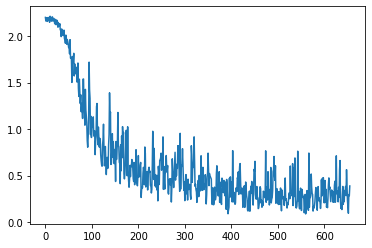

In [8]:
plt.plot(range(len(loss_log)), loss_log)
plt.show()

In [12]:
print(t_train.shape)
batch_size = 200
total_correct = 0

running_loss = 0.0
accuracy = 0.0
test_size = 1000
test_data_idx = np.random.choice(x_test.shape[0], test_size)
for i in tqdm(test_data_idx):
    x = x_test[i].reshape(1, 1, 28, 28)
    labels = t_test[i]

    outputs = model.forward(x)
    pred = ops.Softmax(outputs)
    labels = labels.reshape(pred.shape)
    c = (np.argmax(labels, 1) == np.argmax(pred, 1)).squeeze()
    total_correct += np.sum(c)

print(f"Accuracy:{total_correct/test_size}")


(60000, 10)


100%|██████████| 1000/1000 [00:10<00:00, 93.21it/s]

Accuracy:0.933
